# Unsupervised Deep Embedding Clustering for Zooniverse

Use the approach from [Unsupervised Deep Embedding for Clustering Analysis](https://arxiv.org/abs/1511.06335). I'm using the keras implementation [here](https://github.com/XifengGuo/DEC-keras).

The algorithm uses greedy layer-wise pretaining of a [deep denoising autoencoder](https://blog.keras.io/building-autoencoders-in-keras.html) to learn an initial embedding that minimises reconstruction loss.  Clusters are then initialised using K-means.  Training examples (subjects) are then encoded by the auto encoder and assigned to clusters by a soft assignment based on proximity to a cluster centre.  The network parameters and cluster centres are then further trained by minimising the KL divergence between the soft cluster assignments and an auxiliary distribution.  The auxiliary distribution assumes that those examples lying closest to a cluster centre have a high confidence of belonging to the same class (or at least share some relationship that is worth reinforcing).  The auxiliary distribution also normalises the loss contribution of each centroid such that the loss is not completely dominated by the largest centroids.

Applying this to Zooniverse.

#### Experiment 1 - Exploring DEC

- ##### Experiment 1a
Run the MNIST experiment from the original paper.  This is our completely unsupervised benchmark.  The clusters currently have no meaning.

- ##### Experiment 1b
Try different training set sizes.  The original paper uses the entire 70000 MNIST data set.  We should experiment with how varying the size of the initial training affects performance.  For some of our experiments we will need a test set, so we should at least hold out the 10000 MNIST test set subjects reducing the training set size to 60000 subjects.  

- ##### Experiment 1c
Experiment with the number of clusters we use.  The paper uses 10 clusters but this is based on prior knowledge of the data set.  Using many more clusters will produce smaller but purer clusters with the trade-off that they require more human input.

- ##### Experiment 1d
Experiment with including the test set during the DEC training phase and not including it.  The former replicates the scenario where a Zooniverse project has all the data they want to classify upfront.  The latter is the case where we expect new data to be continually added to the project and can't include that data while training DEC.

#### Experiment 2 - incorportating citizen scientists

- ##### Experiment 2a
Simulate querying cluster labels from volunteers for the clustering in experiment 1. This is simply done by assigning the majority cluster class to to each cluster.

- ##### Experiment 2b
Design a mapping layer that can be tacked onto the network created in experiment 1.  This layer must generalise to the case where there are more clusters than classes.

- ##### Experiment 2c
Train the network with the MNIST labels.  This replicates querying labels from perfect classifiers for every subject in the MNIST data set.  In this case we simulate crowd sourcing the cluster labels (Experiment 2a) and then crowd sourcing labels for every subject in the data set to identify misclassified subjects that can be used to further refine the learned feature space.

- ##### Experiment 2d
Experiment with differing levels of volunteer classification noise.

- ##### Experiment 2e
Try to find more efficient methods for identifying misclassified subjects.  We want to do better than simply querying labels for every subject in the data set as done in Experiment 2c.

#### Experiment 3 - application to a real data set
Repeat experiment 1 and 2 for Supernova Hunters data.

#### Experiment 4 - application to natural images using weel known data sets
Repeat experiment 1 and 2 for CIFAR-10, CIFAR-100 and STL-10 datasets.  These are more similar to ecology projects.  STL-10 in particular might be interesting as there are only 500 training images and 800 test images  per class but has 100000 unlabelled images.  Might be interesting to test serendipitous discovery and the presence of uninteresting classes.  We could also test transfer learning between data sets.

#### Experiment 5 - application to ecology projects
Repeat experiment 1 and 2 but with Marcos Ecology Project data set.

#### Experiment 6 - using a pretrained CNN to replace stacked denoising autoencoders
Use Marcos pretrained CNN to replace the deep autoencoder in experiment 1.  This investigates transfer learning applied to our clustering approach to gathering labels.

#### Experiment 7 - designing a system to dissolve clusters
How can the idea of dissolving clusters be incorporated into the network architecture.  Should we just 'delete' that cluster in which case all its members will be assigned to their next best cluster? Should we just randomly reinitialise the cluster (this runs the risk of undoing earlier training)? Should we divide the cluster into 2 new clusters with the new cluster centres initialised based on some information we have about where different classes lie within the original cluster.

## Setup

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from time import time

In [2]:
from keras.models import Model
from keras.layers import Input, Dense, Lambda
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.engine.topology import Layer
from keras import backend as K

Using TensorFlow backend.


In [41]:
np.random.seed(0)

Import the DEC implementation and various helper functions from the DEC-keras repository.

In [3]:
sys.path.insert(0,'../DEC-keras/')

In [4]:
from DEC import DEC, ClusteringLayer, cluster_acc

## Experiment 1
### Experiment 1a - replicate results of original DEC paper

Load the mnist data set normalised as in the DEC paper.

In [5]:
from datasets import load_mnist

In [6]:
x, y = load_mnist()

MNIST samples (70000, 784)


Define some contants from the paper.

In [7]:
n_clusters = 10 # this is chosen based on prior knowledge of classes in the data set.
batch_size = 256
lr         = 0.01 # learning rate
momentum   = 0.9
tol        = 0.001 # tolerance - if clustering stops if less than this fraction of the data changes cluster on an interation

Define some constants for this implementation

In [8]:
maxiter         = 2e4
update_interval = 140
save_dir         = '../DEC-keras/results/dec'

In [9]:
# prepare the DEC model
dec = DEC(dims=[x.shape[-1], 500, 500, 2000, 10], n_clusters=n_clusters, batch_size=batch_size)

I have already run the greedy layer-wise pretraining so tell DEC where to find those. 

In [10]:
ae_weights = '../DEC-keras/ae_weights.h5'

In [11]:
dec.initialize_model(optimizer=SGD(lr=lr, momentum=momentum),
                     ae_weights=ae_weights,
                     x=x)

Display a summary of the model archietecture.

In [12]:
dec.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 784)               0         
_________________________________________________________________
encoder_0 (Dense)            (None, 500)               392500    
_________________________________________________________________
encoder_1 (Dense)            (None, 500)               250500    
_________________________________________________________________
encoder_2 (Dense)            (None, 2000)              1002000   
_________________________________________________________________
encoder_3 (Dense)            (None, 10)                20010     
_________________________________________________________________
clustering (ClusteringLayer) (None, 10)                100       
Total params: 1,665,110.0
Trainable params: 1,665,110.0
Non-trainable params: 0.0
____________________________________________________________

In [13]:
try:
  dec.load_weights('../DEC-keras/results/DEC_model_final.h5')
  y_pred = dec.predict_clusters(x)
except IOError:
  t0 = time()
  y_pred = dec.clustering(x, y=y, tol=tol, maxiter=maxiter,
                          update_interval=update_interval, save_dir=save_dir)
  print('clustering time: ', (time() - t0))
print('acc:', cluster_acc(y, y_pred))

acc: 0.874085714286


The above gives our unsupervised benchmark accuracy of 87.40% on the entire MNIST data set (70000 subjects).  For a Zooniverse project we would have no idea what this value is unless, for some reason, we have labels for every subject upfront.  We may have a smaller sample of labelled data that can give us an estimate of the unsupervised performance but with some unknown error.

### Experiment 1b - training set sizes

I have trained DEC on training set sizes in the range 100-60000.  I will measure the unsupervised accuracy on these using the entire data set of 70000 subjects.  This represents the case where we have a limited data set at the start of a Zooniverse project with which to train DEC, but then use DEC to cluster new data unseen by DEC during training.

In [14]:
training_set_sizes = [100, 500, 1000, 5000, 10000, 50000]
path_to_weights = '../experiments/Unsupervised_Deep_Embedding_Clustering_for_Zooniverse/experiment1b'

In [15]:
accs = []
tmp_dec = DEC(dims=[x.shape[-1], 500, 500, 2000, 10], n_clusters=n_clusters, batch_size=batch_size)
for training_set_size in training_set_sizes:
  tmp_dec.initialize_model(optimizer=SGD(lr=lr, momentum=momentum),
                       ae_weights=path_to_weights+'/ae_weights_m%d.h5'%training_set_size,
                       x=x)
  tmp_dec.load_weights(path_to_weights+'/results/dec/%d'%(training_set_size)+'/DEC_model_final.h5')
  tmp_y_pred = tmp_dec.predict_clusters(x)
  acc = cluster_acc(y, tmp_y_pred)
  accs.append(acc)
  print('acc:', acc)
accs.append(0.874085714286) # add the performance of training on all 70000 subjects
training_set_sizes.append(70000)

acc: 0.481814285714
acc: 0.542085714286
acc: 0.454742857143
acc: 0.661014285714
acc: 0.778542857143
acc: 0.852642857143


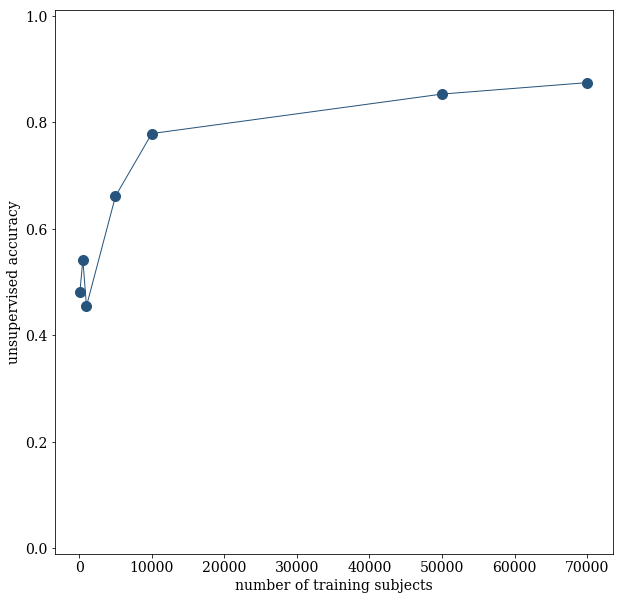

In [16]:
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Helvetica']
rcParams['font.size'] = 14
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(training_set_sizes, accs, 'o', color='#26547C', ms=10)
ax.plot(training_set_sizes, accs, '-', color='#26547C', lw=1)
#ax.set_xticks(training_set_sizes)
ax.set_ylim(-0.01,1.01)
ax.set_xlabel('number of training subjects')
ax.set_ylabel('unsupervised accuracy')
plt.show()

## Experiment 2
### Experiment 2a - simulate querying cluster meanings
Lets calculate some statistics for each cluster (again these require knowing the labels which we won't in a real project).  We will also simulate the assignment of a label to each cluster by taking the majority cluster class for each cluster.

In [45]:
n_classes = 10 # We know this from the data, but may not for a real project

one_hot_encoded = np_utils.to_categorical(y, n_classes)

cluster_to_label_mapping = [] # will be a mapping from the cluster index to the label assigned to that cluster
majority_class_pred = np.zeros(y.shape)
for cluster in range(n_clusters):
  cluster_indices = np.where(y_pred == cluster)[0]
  n_assigned_examples = cluster_indices.shape[0]
  cluster_labels = one_hot_encoded[cluster_indices]
  cluster_label_fractions = np.mean(cluster_labels, axis=0)
  majority_cluster_class = np.argmax(cluster_label_fractions)
  cluster_to_label_mapping.append(majority_cluster_class)
  majority_class_pred[cluster_indices] += majority_cluster_class
  print(cluster, n_assigned_examples, majority_cluster_class, cluster_label_fractions[majority_cluster_class])
print(cluster_to_label_mapping)

0 6991 8 0.942783578887
1 6924 0 0.984979780474
2 7227 7 0.969420229694
3 7418 3 0.925721218657
4 6485 4 0.518735543562
5 7717 1 0.989762861215
6 7091 2 0.955436468763
7 6221 5 0.946632374216
8 7252 9 0.505102040816
9 6674 6 0.984866646689
[8, 0, 7, 3, 4, 1, 2, 5, 9, 6]


Now lets visulaise 100 random samples from each cluster.  This could be what we ask citizen scientists to classify.

In [18]:
def getDimensions(n):
  dim = int(np.ceil(np.sqrt(n)))
  return (dim, dim)

In [19]:
def plotCluster(cluster_labels, cluster, X, image_dim, limit=200, cmap='gray_r'):
  indices = np.where(cluster_labels == cluster)[0] # get the examples assigned to cluster 0
  order = np.random.permutation(len(indices))
  indices = indices[order]
  n = np.where(cluster_labels == cluster)[0].shape[0]
  print(n)
  if n > limit:
    indices = indices[:limit]
    n = limit
    
  dims = getDimensions(n)
    
  fig = plt.figure(figsize=(10,10))
  for i in range(n):
    ax = fig.add_subplot(dims[0],dims[1],i+1)
    ax.imshow(np.reshape(X[indices[i]], (image_dim,image_dim), order='C'), cmap=cmap)
    plt.axis('off')
  plt.show()

6485


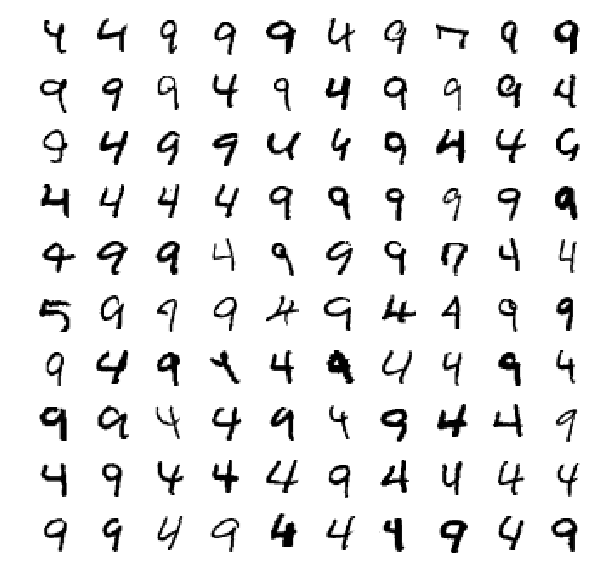

In [20]:
plotCluster(y_pred, 4, x, 28, limit=100) # this would be a candidate to dissolve

6924


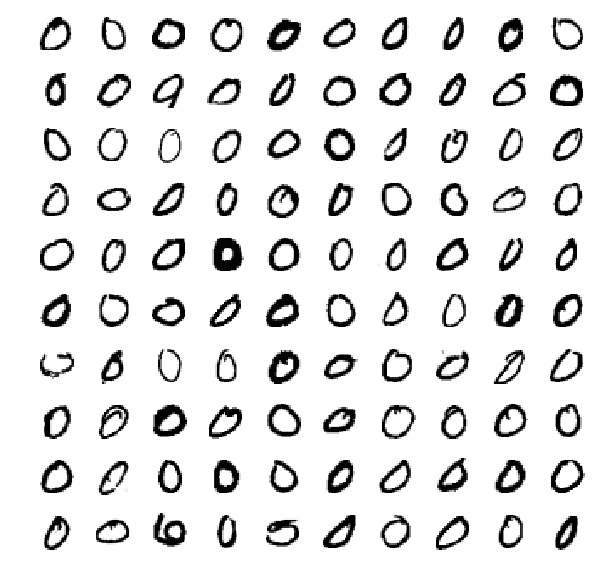

In [21]:
plotCluster(y_pred, 1, x, 28, limit=100)

7227


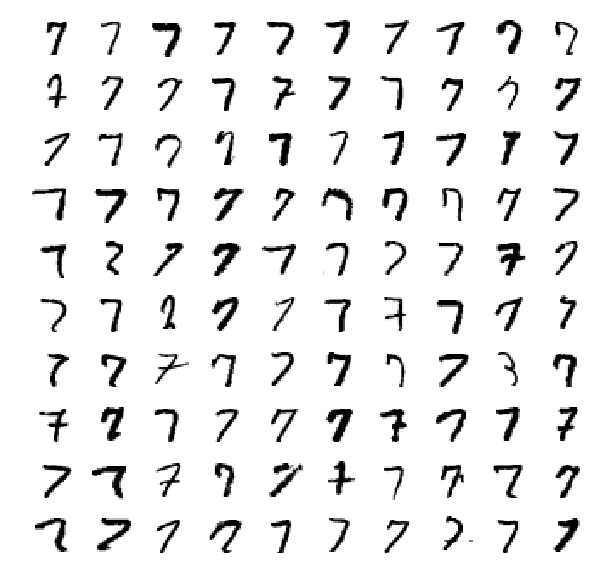

In [22]:
plotCluster(y_pred, 2, x, 28, limit=100)

Some of the clusters look pretty good and some have a mixture of classes.  So lets say we have now queried the meaning of the clusters.  I'm going to assume that the citizen scientists returned the meaning corresponding to the mjority class of each cluster.  This assumption is weakest for the clusters with a significant mixture of classes, it is unclear what 'meaning' would have been returned, but this situation could potentially be dealt with by the idea of dissolving clusters which we will experiment with later.

### Experiment 2b - design the mapping layer

I want to tag an extra layer onto our DEC model.  This layer maps the DEC outputs which are soft assignments to cluster centres (q in the paper) to softmax labels.  I assign the clusters to a label by mapping the neurons in the clustering layer to the neuron correponding to the correct label in this new output layer.  I call this a mapping layer as it just defines which neurons in the previous layers should be connected to which in the mapping layer i.e. it is not trainable.  For example if cluster 5 happens to be dominated by 2's then I map the 6th neuron in the clustering layer to the 3rd neuron in the mapping layer (indexing from 0). 

In the mapping layer I also pass the soft assignments from the clustering layer through the softmax function, but I'm not completely convinced this is needed as the assignments might be good enough for training with categorical cross entropy.

In [23]:
class MappingLayer(Layer):

  def __init__(self, mapping, output_dim, **kwargs):
    self.output_dim = output_dim
    # mapping is a list where the index corresponds to a cluster and the value is the label.
    # e.g. say mapping[0] = 5, then a label of 5 has been assigned to cluster 0
    self.n_classes = np.unique(mapping).shape[0]      # get the number of classes
    self.mapping = K.variable(mapping, dtype='int32')
    super(MappingLayer, self).__init__(**kwargs)

  def build(self, input_shape):
    super(MappingLayer, self).build(input_shape)  # Be sure to call this somewhere!

  def call(self, x):
    # create a matrix of zeros and ones that maps the correct neurons from the clustering layer 
    # to the output neuron corresponding to that cluster's label.
    mapping = K.one_hot(self.mapping, self.n_classes)
    # sum up the all the soft assignments to clusters with the same labels and calculate the softmax
    # of that sum to produce a probability.
    return K.softmax(K.dot(x, mapping))

  def compute_output_shape(self, input_shape):
    return (input_shape[0], self.output_dim)

Now we can build the model using the Keras functional API.

In [24]:
a = Input(shape=(784,)) # input layer
q = dec.model(a) # the Deep Embedding Cluster we trained above
# stick on the mapping layer, where the label is given by the majority class of a cluster
pred = MappingLayer(cluster_to_label_mapping, output_dim=n_classes)(q)
model = Model(inputs=a, outputs=pred)
# use categorical cross entropy as we now have a classification task
model.compile(loss='categorical_crossentropy', optimizer='adam')

### Some sanity checking.

Before we train the network any further we can check that the new Mapping Layer is doing what I expect.  If we take the argmax of the output of this network, it will give me a predicted label in [0,9).  If I check these predictions against the true labels I should get the exact same accuracy as I got from DEC.  This only works here because the number of clusters and the number of classes are the same and because each cluster has been assigned a unique label.

In [25]:
def calculateAccuracy(model, x, y, n_classes):
  preds = model.predict(x)
  return 100*np.sum(np.argmax(preds, axis=1)== np.argmax(np_utils.to_categorical(y, n_classes), axis=1))/ len(preds)

In [26]:
preds = model.predict(x) # get the predictions of the model for each subject
print(np.argmax(preds, axis=1)) # get the armax of the predictions i.e. the predicted label
print(y)                        # print out the true label for comparison 
print('acc:', calculateAccuracy(model, x, y, 10)) # calculate the accuracy of the model
print('acc:', cluster_acc(y, y_pred)*100) # calculate the accuracy of DEC alone

[5 0 4 ..., 9 5 6]
[5 0 4 ..., 4 5 6]
acc: 87.4085714286
acc: 87.4085714286


If the model is outputting the correct prediction then its predictions should exactly match the labels given by DEC cluster assignments.

In [27]:
# cluster assignments must be mapped to labels
print(np.all(np.argmax(preds, axis=1) == np.array(cluster_to_label_mapping)[y_pred]))

True


### Experiment 2c - simulate further trianing the network on queried labels

In this experiment I am going to assume that we have queried labels for the 60000 subjects in the MNIST training set.  I will train the model using these labels and test the performance on the 10000 subjects in thebtest set.  This simulates querying perfect classifiers for labels for ~85% of the data set and then applying the model to the remaining 15% of the data.  In reality this is really just another test of the mapping layer.

First calculate the performance of the model on the training and test sets individually so we have a benchmark.  If we can do better than these then the model is able to use the mapping layer to learn from individual labels.

In [ ]:
print('training acc:', calculateAccuracy(model, x[:60000], y[:60000], 10)) # training set performance
print('test acc:', calculateAccuracy(model, x[60000:], y[60000:], 10)) # test set performance

training acc: 87.42
test acc: 87.34


In [34]:
model.fit(x[:60000], np_utils.to_categorical(y[:60000], n_classes), epochs=10, batch_size=256)

Epoch 1/10
60000/60000 [==============================] - 31s - loss: 1.4841      

Calculate the performance ont the training set.

In [35]:
print('training acc:', calculateAccuracy(model, x[:60000], y[:60000], 10))

training acc: 99.7216666667


Calculate the performance on the test set.  The model has "seen" these subjects during the unsupervised stage but we have not queried volunteers for their label.

In [36]:
print('test acc:', calculateAccuracy(model, x[60000:], y[60000:], 10))

test acc: 98.56


This shows that we can further train the model by using labels for individual subjects.

### Experiment 2e - selecting which subjects humans should classify

#### Random subsample

In [43]:
experiment_dir = '../Unsupervised_Deep_Embedding_Clustering_for_Zooniverse/experiment2e'

In [57]:
def build_model():
  dec.initialize_model(optimizer=SGD(lr=lr, momentum=momentum),
                       ae_weights='../DEC-keras/ae_weights.h5',
                       x=x)
  dec.load_weights('../DEC-keras/results/dec/DEC_model_final.h5')
  a = Input(shape=(784,)) # input layer
  q = dec.model(a)
  pred = MappingLayer(cluster_to_label_mapping, output_dim=n_classes)(q)
  model = Model(inputs=a, outputs=pred)
  model.compile(loss='categorical_crossentropy', optimizer='adam')
  return model 

In [58]:
training_set_sizes = [100, 500, 1000, 5000, 10000, 25000, 60000]
m = 60000
x_test  = x[m:]
y_test  = y[m:]
accs = []
for training_set_size in training_set_sizes:
  model_random = build_model()
  x_train = x[:training_set_size]
  y_train = y[:training_set_size]
  model_random.fit(x_train, np_utils.to_categorical(y_train), epochs=10, batch_size=256)
  accs.append(calculateAccuracy(model_random, x_test, y_test, 10))

Epoch 1/10
100/100 [==============================] - 0s - loss: 2.3070
Epoch 2/10
100/100 [==============================] - 0s - loss: 2.2931
Epoch 3/10
100/100 [==============================] - 0s - loss: 2.2325
Epoch 4/10
100/100 [==============================] - 0s - loss: 2.2104
Epoch 5/10
100/100 [==============================] - 0s - loss: 2.1894
Epoch 6/10
100/100 [==============================] - 0s - loss: 2.1609
Epoch 7/10
100/100 [==============================] - 0s - loss: 2.1295
Epoch 8/10
100/100 [==============================] - 0s - loss: 2.0835
Epoch 9/10
100/100 [==============================] - 0s - loss: 2.0585
Epoch 10/10
100/100 [==============================] - 0s - loss: 2.0399
Epoch 1/10
500/500 [==============================] - 2s - loss: 2.3430     
Epoch 2/10
500/500 [==============================] - 0s - loss: 2.2747     

[37.170000000000002, 44.710000000000001, 93.370000000000005, 97.239999999999995, 97.400000000000006, 98.219999999999999, 98.560000000000002]


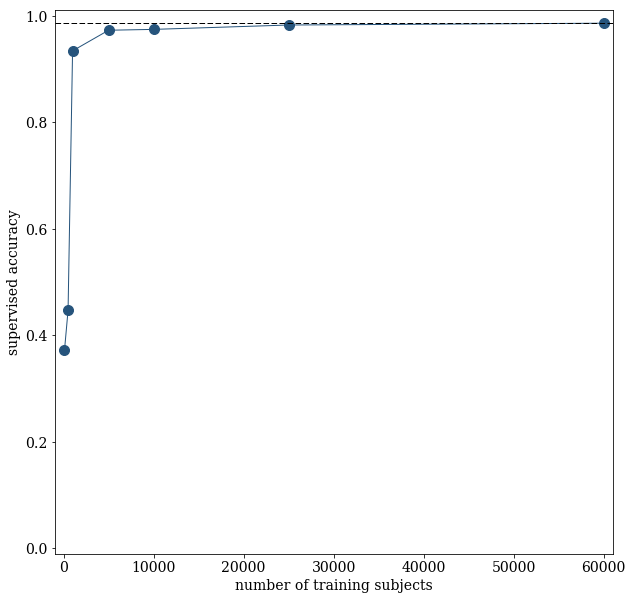

In [70]:
print(accs)
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Helvetica']
rcParams['font.size'] = 14
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(training_set_sizes, np.array(accs)/100., 'o', color='#26547C', ms=10)
ax.plot(training_set_sizes, np.array(accs)/100., '-', color='#26547C', lw=1)
#ax.set_xticks(training_set_sizes)
ax.plot([-1000, 61000],[0.9856, 0.9856],'k--', lw=1)
ax.set_ylim(-0.01,1.01)
ax.set_xlim(-1000,61000)
ax.set_xlabel('number of training subjects')
ax.set_ylabel('supervised accuracy')
plt.show()

## Experiment 3

## Prototyping

You can ignore everything below here.

In [37]:
def tmp(b, mapping):
  # need a zero ones matrix take dot product with input (b in this case) to sum all soft assignments of each 
  # subject to for each clusters corresponding to the same label.
  # b is mxk, there are l labels therefore the output is mxl => kxl
  # mapping is a list where the index correponds to a cluster and the value at that index is the label
  n_classes = np.unique(mapping).shape[0]
  mapping = K.one_hot(mapping, n_classes)
  #order = K.variable([4,3,2,1,0,3],dtype='int32')
  return K.softmax(K.dot(b, mapping))
  #return K.gather(b, order)

#print(K.eval(K.map_fn(tmp,a)))


In [38]:
a = K.variable([[1,2,3,4,5],[6,7,8,9,10]])
mapping = [1,0,0,1,1]
print(K.eval(tmp(a, mapping)))

[[  6.69285096e-03   9.93307173e-01]
 [  4.53978682e-05   9.99954581e-01]]
